# Revisiting the Reservations - EDA and Data Wrangling

---

***Warning: Work-in-Progress***

Originally, I used this notebook to perform EDA with the intention of using the dataset only for classifying whether a reservation would cancel.

Now, as part of my efforts to revisit and revamp this overall repository and workflow, I am updating and adapting it for broader uses, including regression modeling, classification modeling, and time series forecasting.

The end goal is to have a comprehensive overview of the data and to be flexible enough to handle different workflows.


As this is a revamp of the original workbook, some of the code and comments may be outdated. I intend to update and clarify all steps in time, but there may be some parts that are out of place while I clean things up.

---

**Revenue Forecasting**

> Proper revenue forecasting is a critical aspect of the revenue management cycle, with the goal to maximize the hotel's revenues. Using the source dataset from two Portuguese hotels (one in an urban location and another a resort), I will utilize machine learning models to forecast the hotels' average daily rate ("ADR") based on common reservation details that would be known prior to arrival. 
>
> Before I train any models, I need to get an idea of my data, including its data types; distributions; presence/absence of outliers; and to brainstorm ideas for feature engineering.
>
> In this notebook, I explore the original dataset and identify specific features to remove from the data. I will determine whether to keep the feature in my modeling based on my domain knowledge of whether this data is commonly known prior to arrival.
>
> Once the data is prepared, I will perform further modeling and feature engineering in additional notebooks.

---

# Import Packages

In [1]:
import numpy as np
import pandas as pd

## Visualizations
import matplotlib.pyplot as plt
import sweetviz as sv

## Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('display.max_rows', 50)
%matplotlib inline

In [2]:
path = '../../data/source/concatenated_data.parquet'
data = pd.read_parquet(path)
data

IsCanceled  LeadTime  ArrivalDateYear ArrivalDateMonth  \
0                0       342             2015             July   
1                0       737             2015             July   
2                0         7             2015             July   
3                0        13             2015             July   
4                0        14             2015             July   
...            ...       ...              ...              ...   
119385           0        23             2017           August   
119386           0       102             2017           August   
119387           0        34             2017           August   
119388           0       109             2017           August   
119389           0       205             2017           August   

        ArrivalDateWeekNumber  ArrivalDateDayOfMonth  StaysInWeekendNights  \
0                          27                      1                     0   
1                          27                      1                     0   
2                          27                      1                     0   
3                          27                      1                     0   
4                          27                      1                     0   
...                       ...                    ...                   ...   
119385                     35                     30                     2   
119386                     35                     31                     2   
119387                     35                     31                     2   
119388                     35                     31                     2   
119389                     35                     29                     2   

        StaysInWeekNights  Adults  Children  Babies       Meal Country  \
0                       0       2      0.00       0  BB            PRT   
1                       0       2      0.00       0  BB            PRT   
2                       1       1      0.00       0  BB            GBR   
3                       1       1      0.00       0  BB            GBR   
4                       2       2      0.00       0  BB            GBR   
...                   ...     ...       ...     ...        ...     ...   
119385                  5       2      0.00       0  BB            BEL   
119386                  5       3      0.00       0  BB            FRA   
119387                  5       2      0.00       0  BB            DEU   
119388                  5       2      0.00       0  BB            GBR   
119389                  7       2      0.00       0  HB            DEU   

        MarketSegment DistributionChannel  IsRepeatedGuest  \
0              Direct              Direct                0   
1              Direct              Direct                0   
2              Direct              Direct                0   
3           Corporate           Corporate                0   
4           Online TA               TA/TO                0   
...               ...                 ...              ...   
119385  Offline TA/TO               TA/TO                0   
119386      Online TA               TA/TO                0   
119387      Online TA               TA/TO                0   
119388      Online TA               TA/TO                0   
119389      Online TA               TA/TO                0   

        PreviousCancellations  PreviousBookingsNotCanceled  ReservedRoomType  \
0                           0                            0  C                  
1                           0                            0  C                  
2                           0                            0  A                  
3                           0                            0  A                  
4                           0                            0  A                  
...                       ...                          ...               ...   
119385                      0                            0  A                  
1193

# Exploratory Data Analysis: Sweetviz Report

                                             |          | [  0%]   00:00 -> (? left)


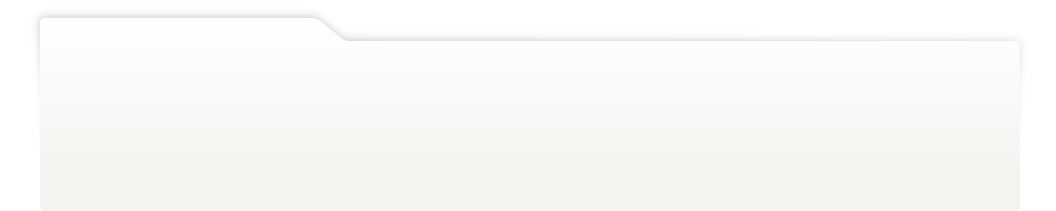
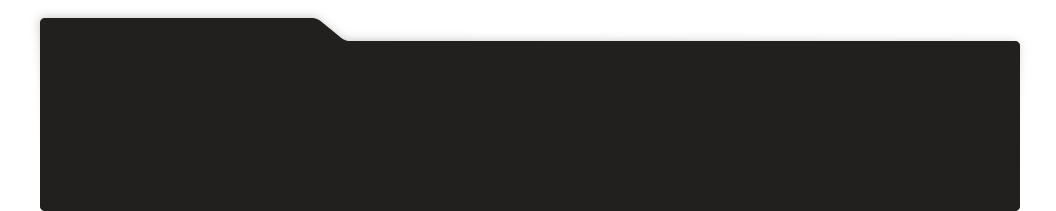
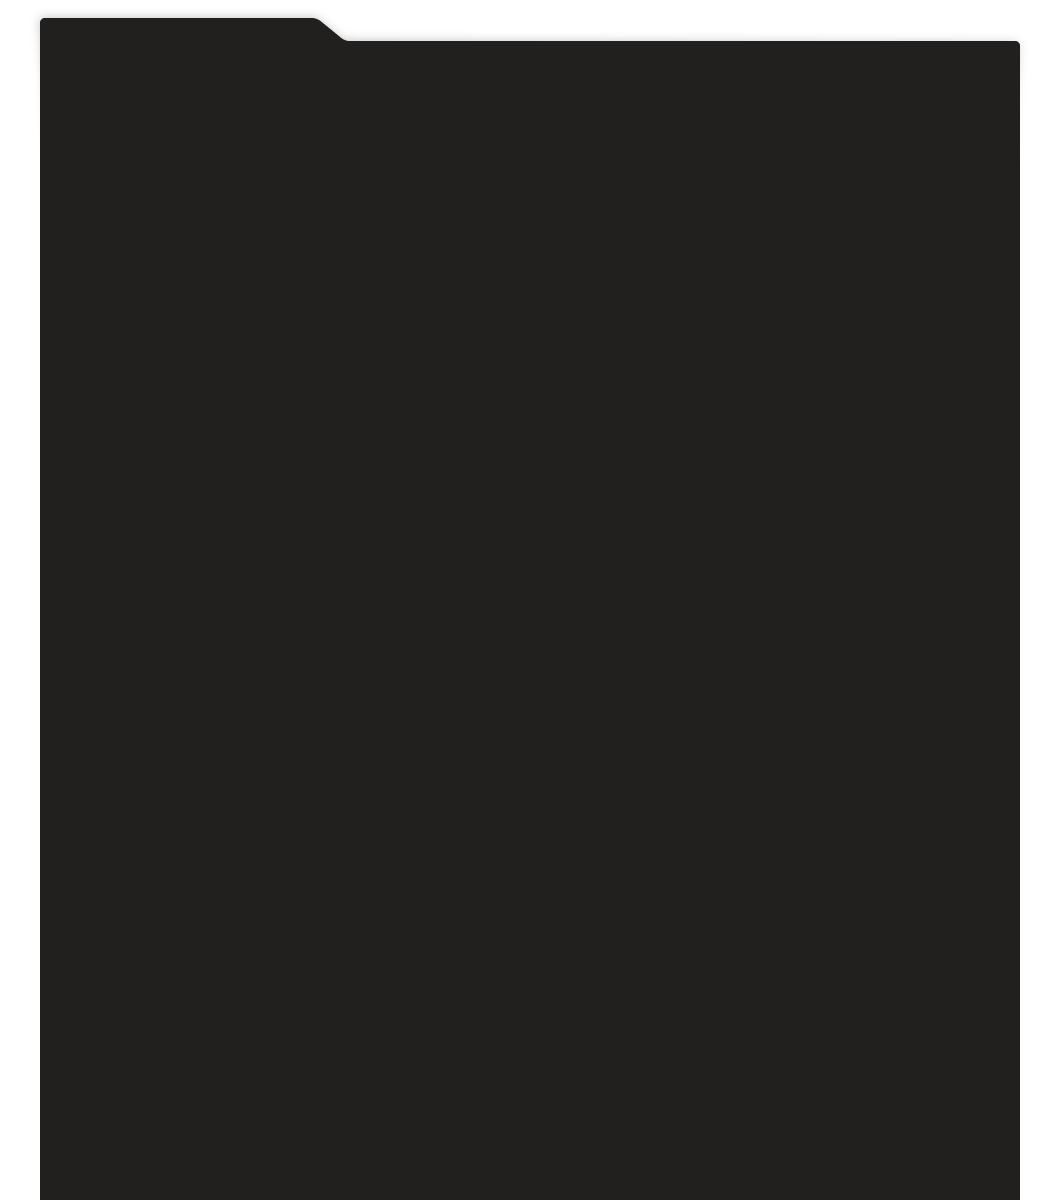
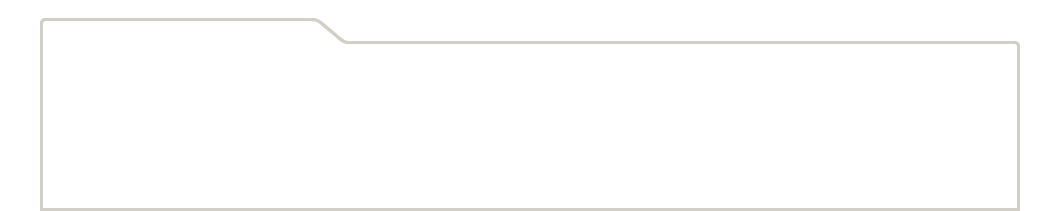
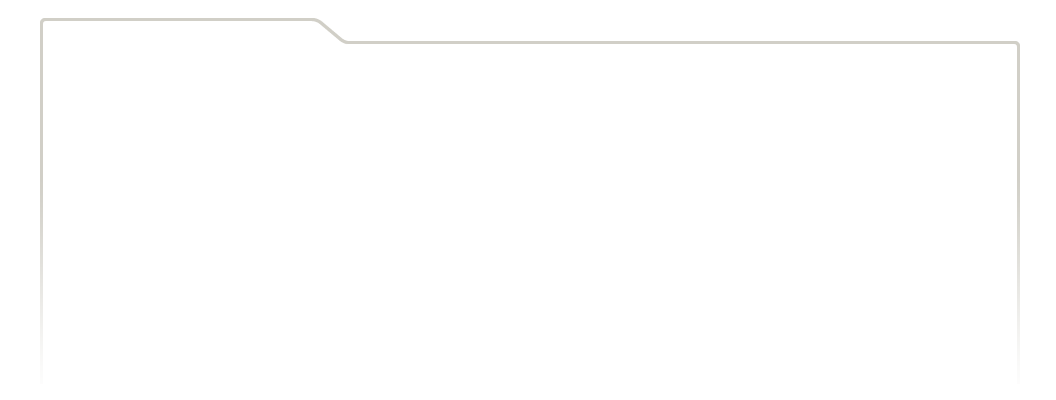
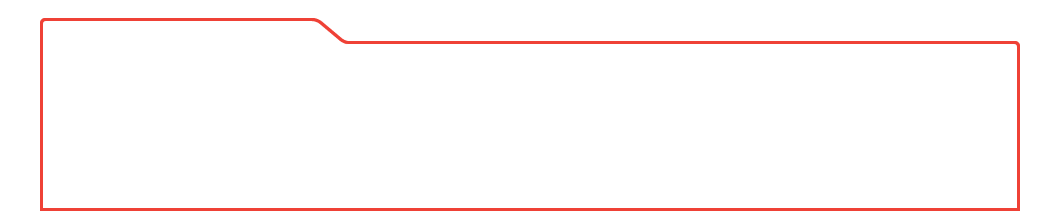
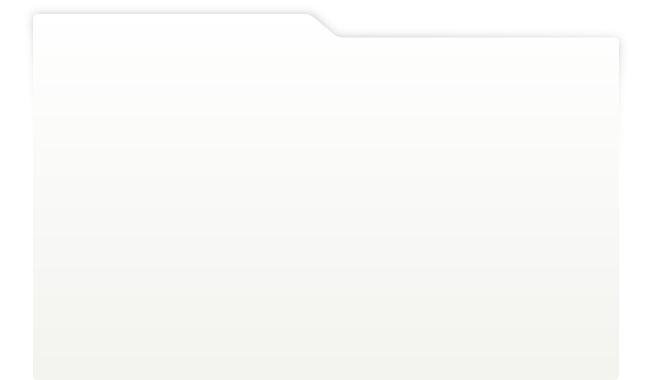
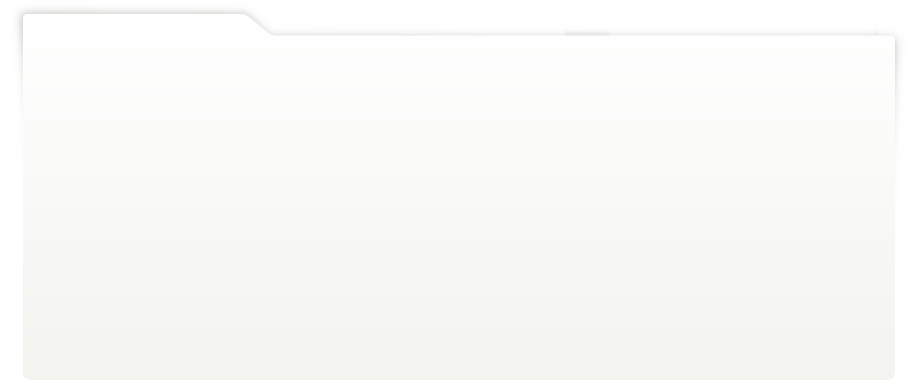
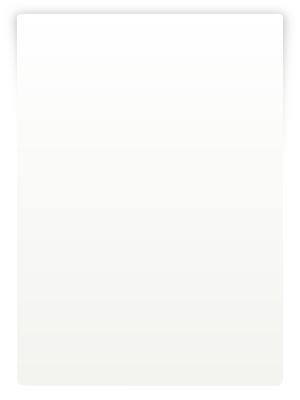
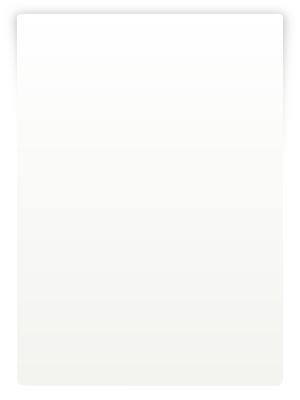
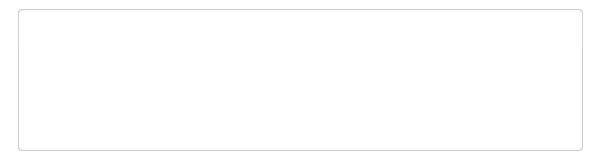
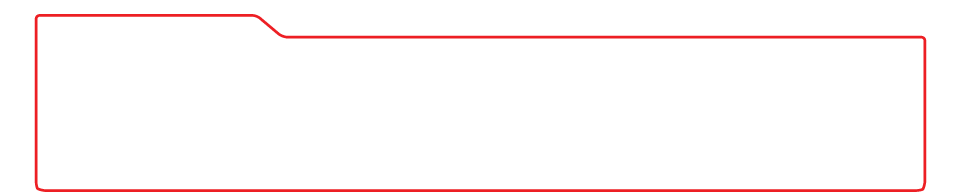
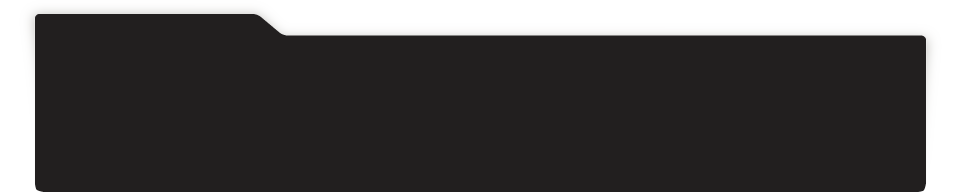
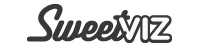
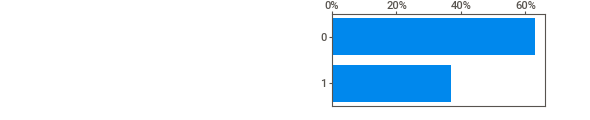
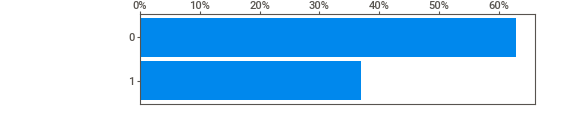
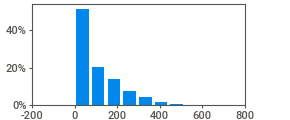
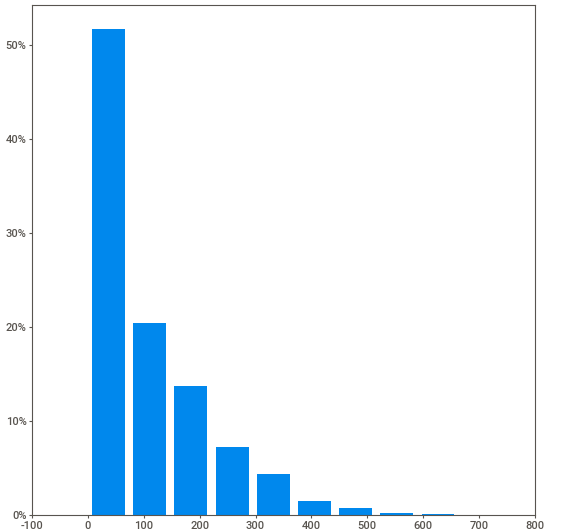
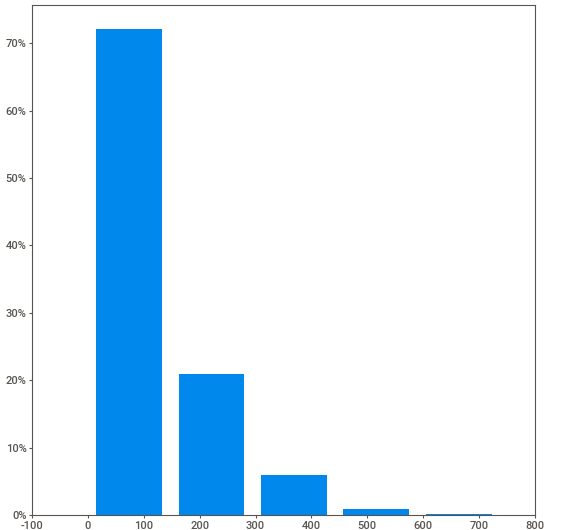
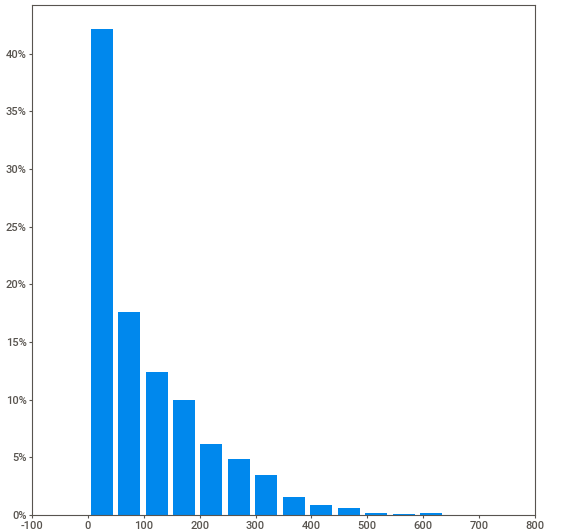
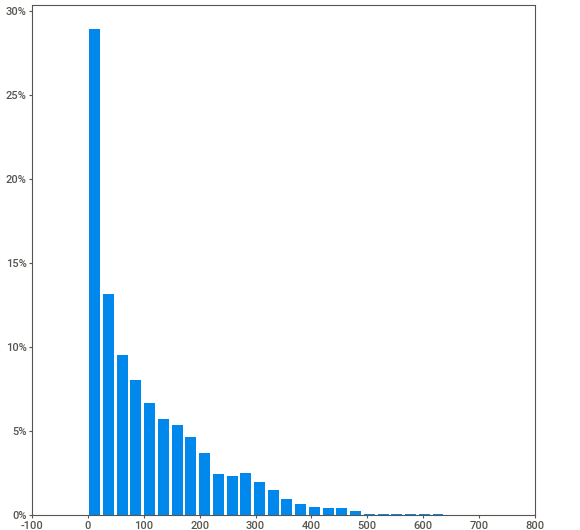
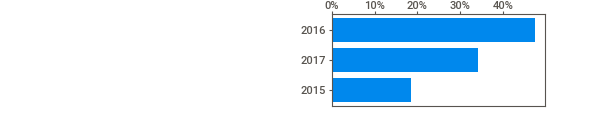
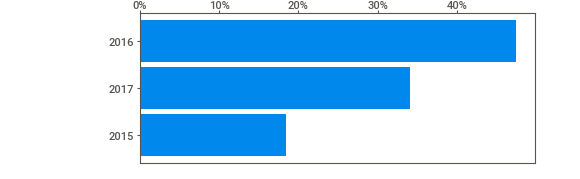
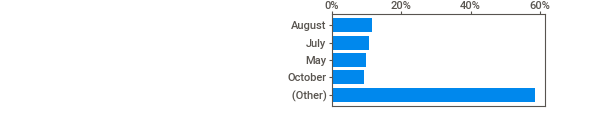
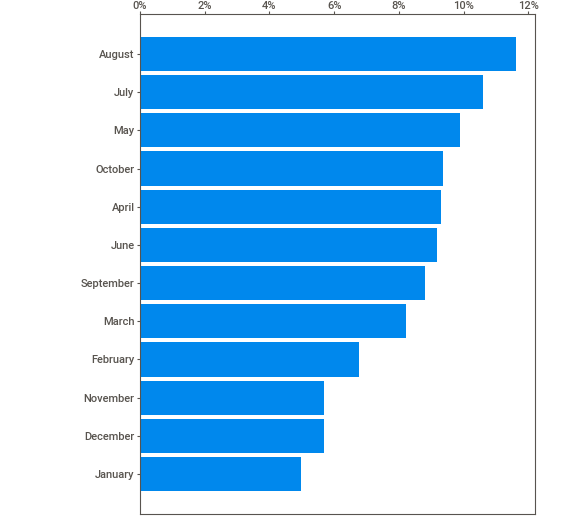
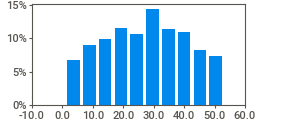
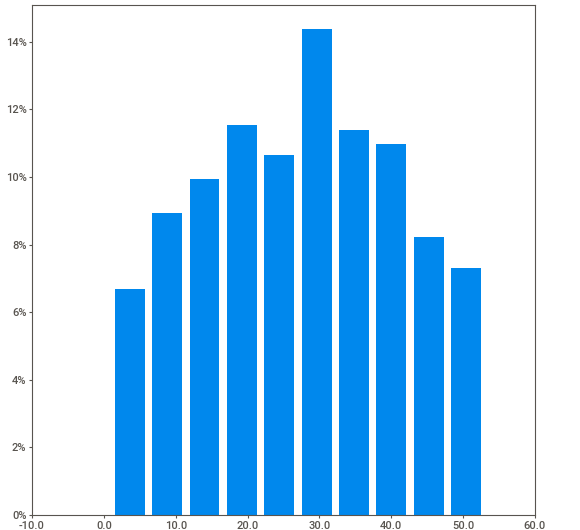
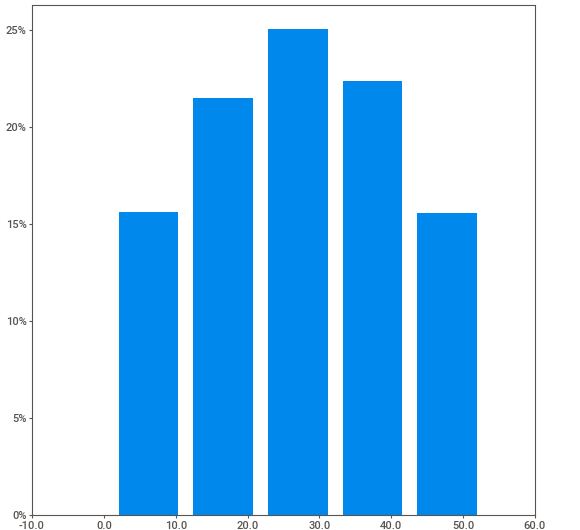
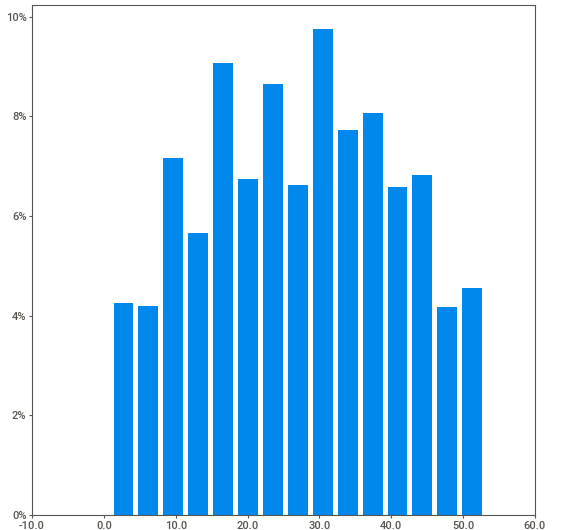
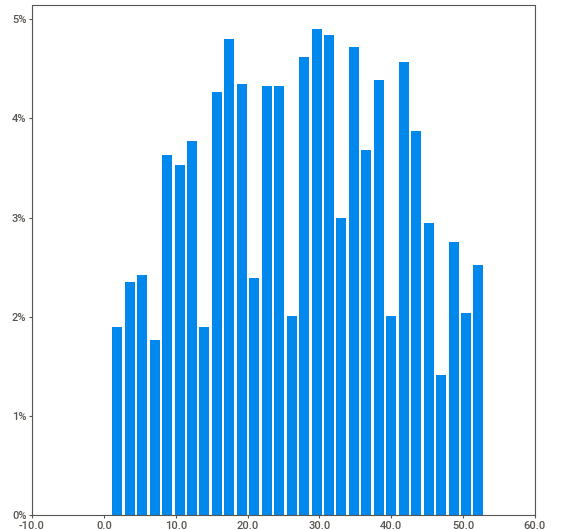
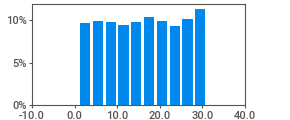
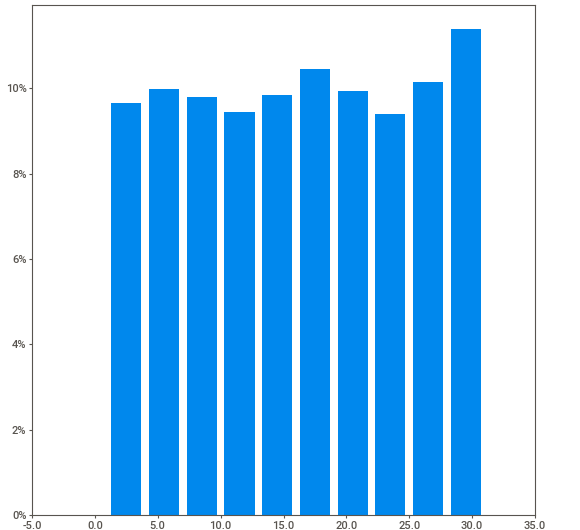
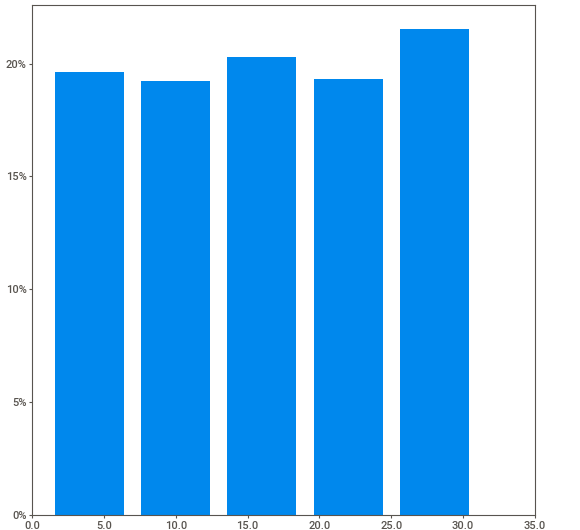
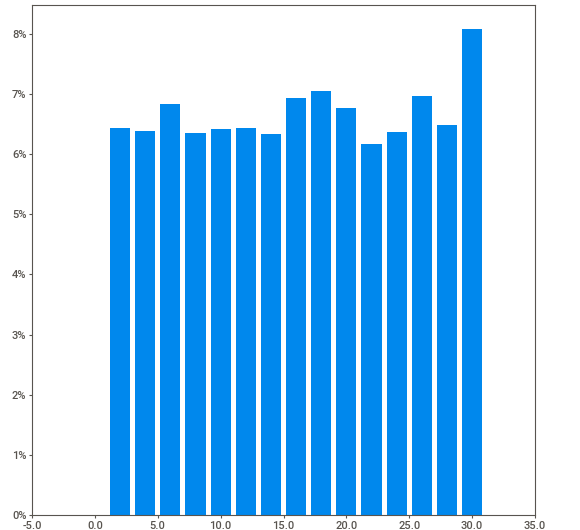
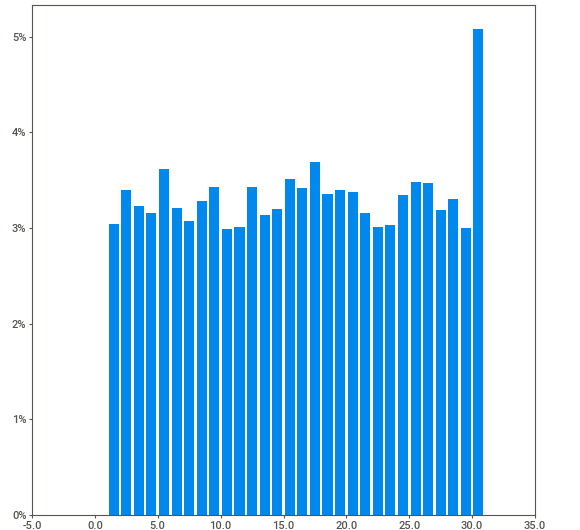
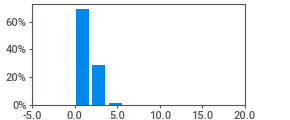
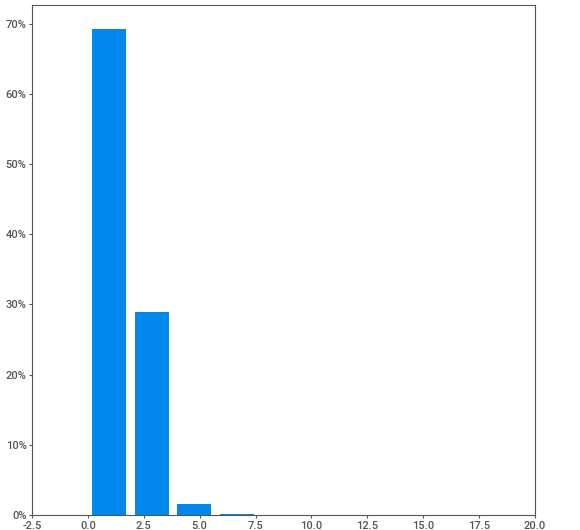
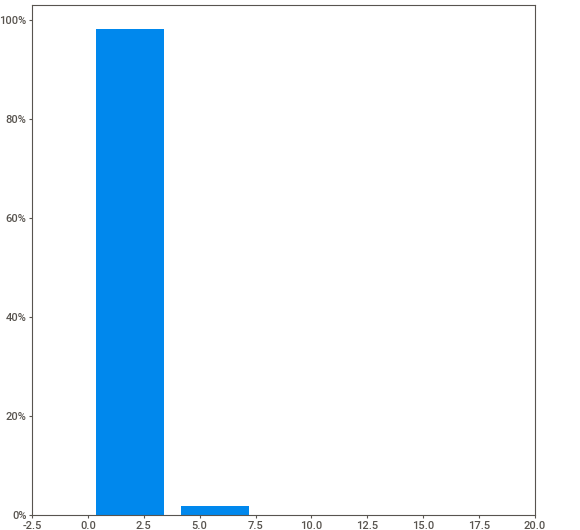
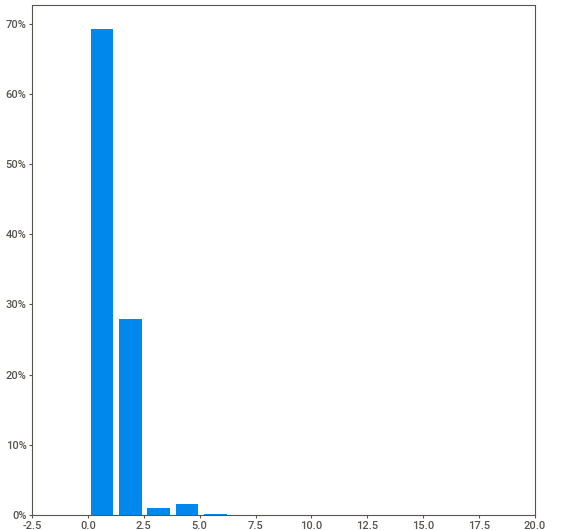
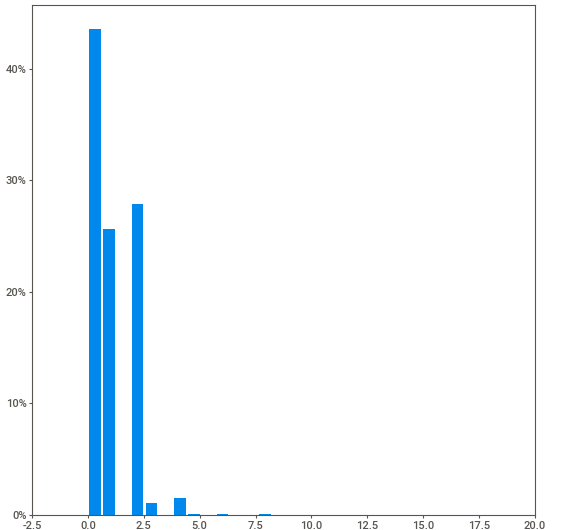
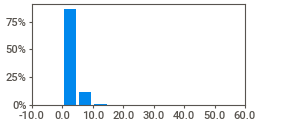
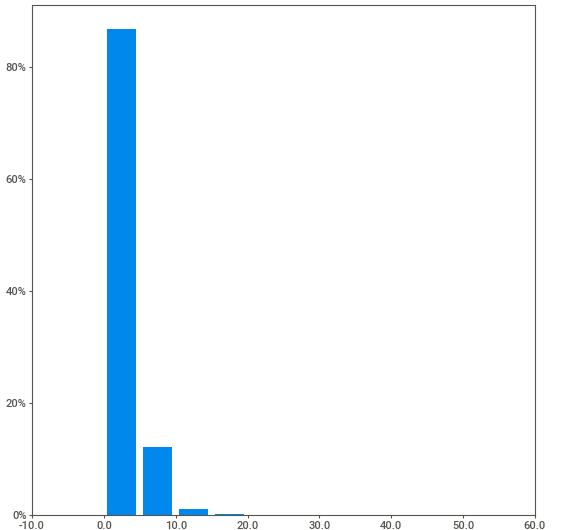
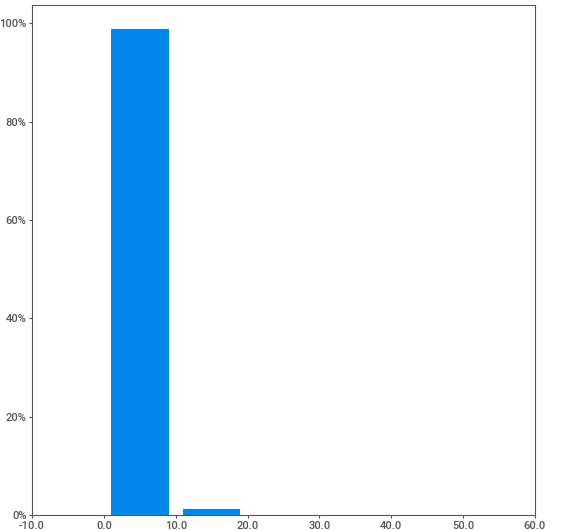
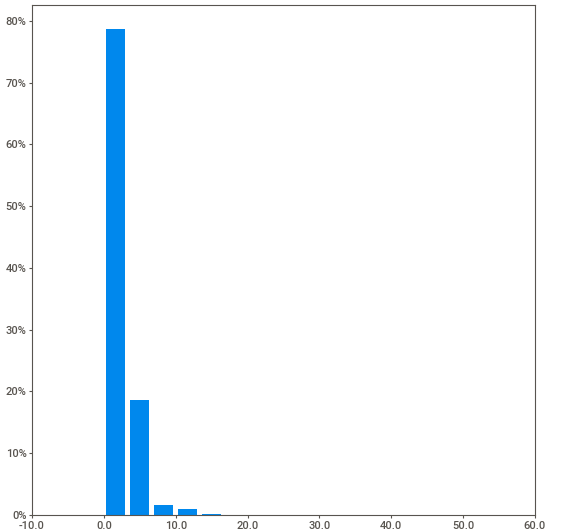
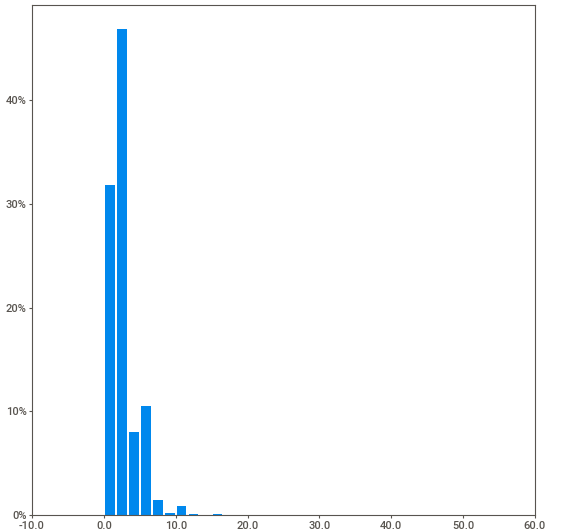
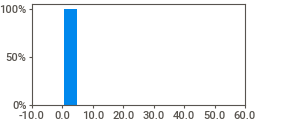
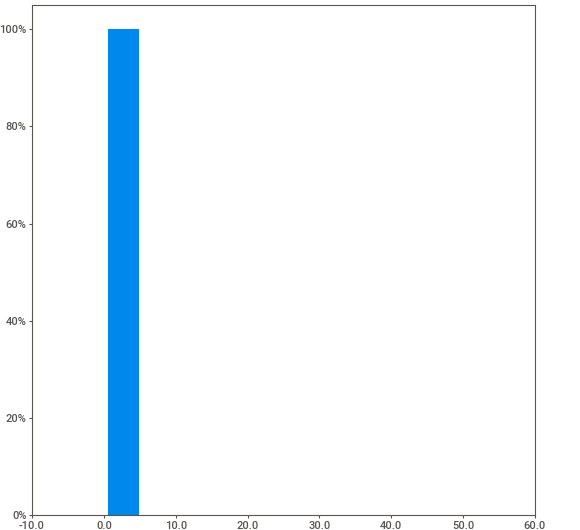
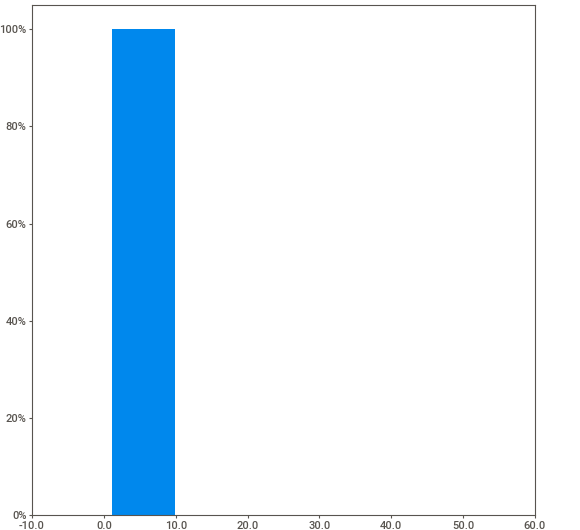
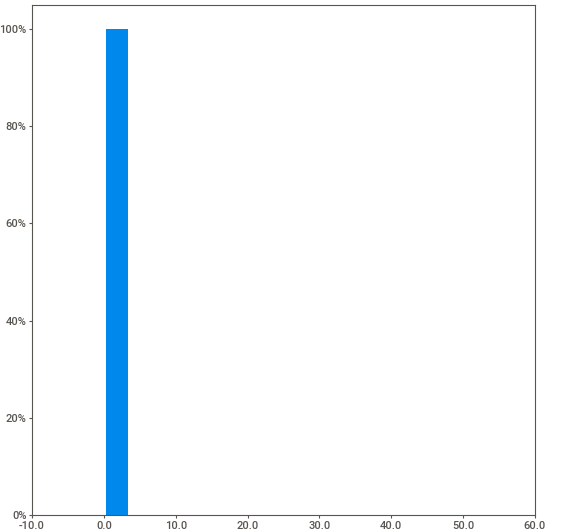
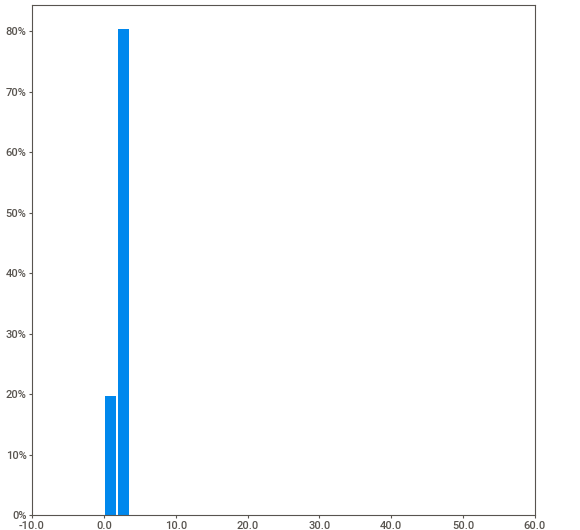
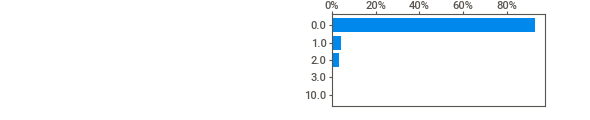
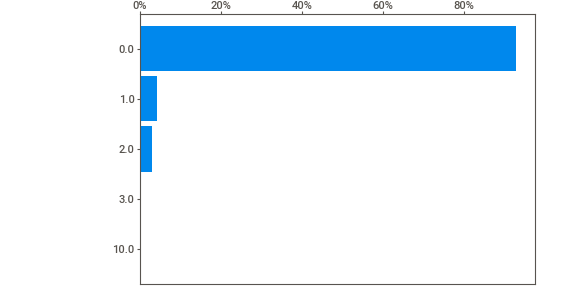
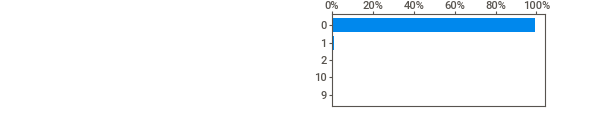
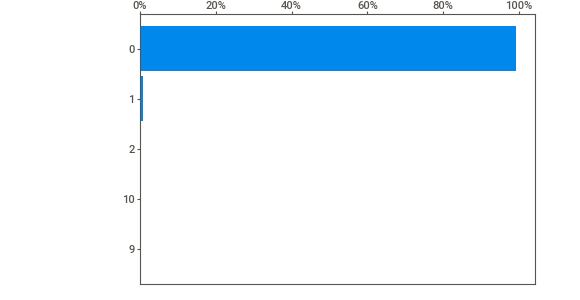
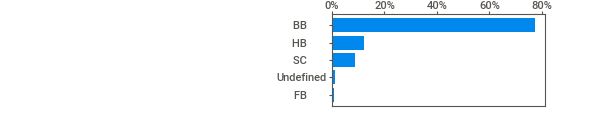
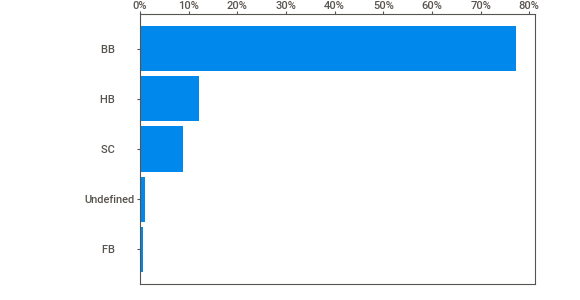
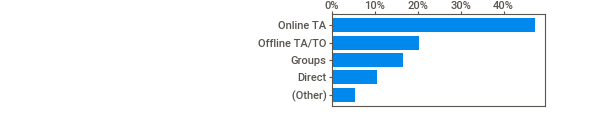
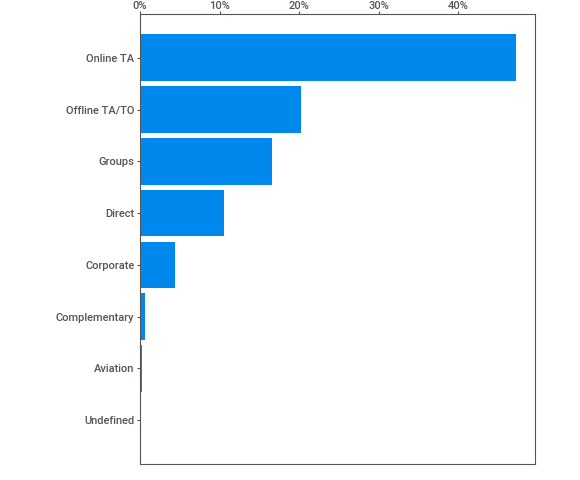
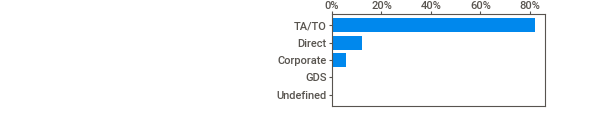
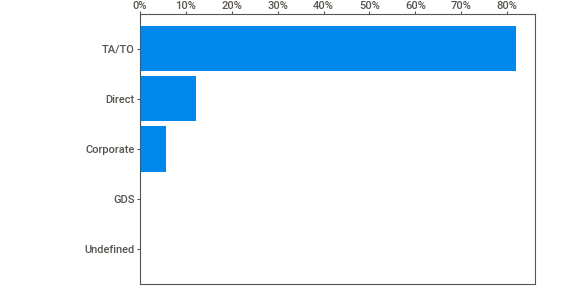
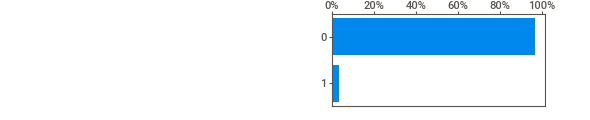
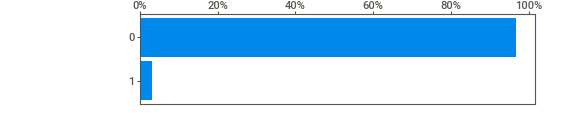
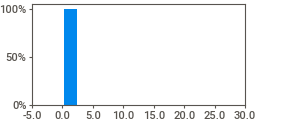
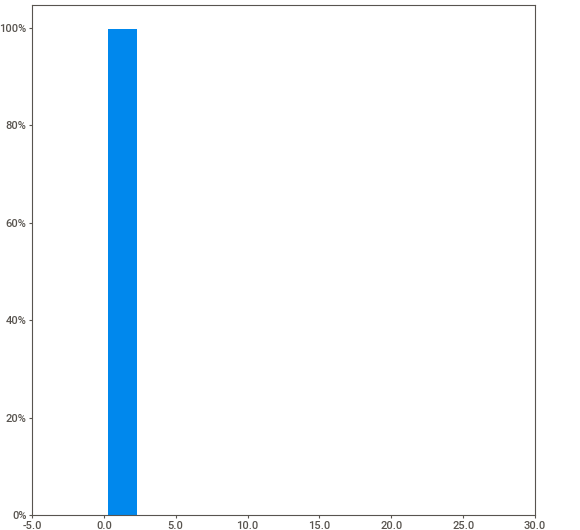
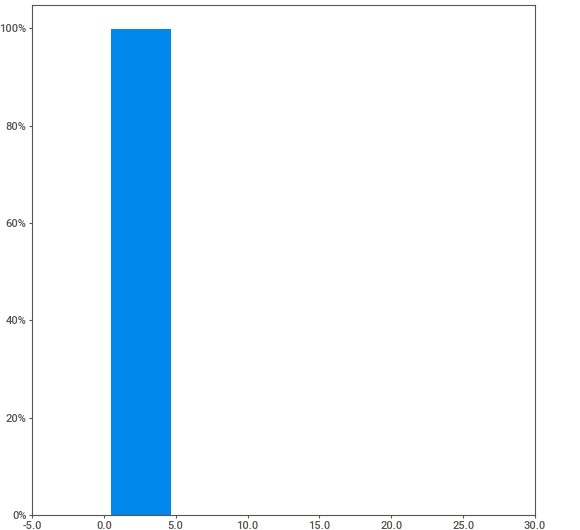
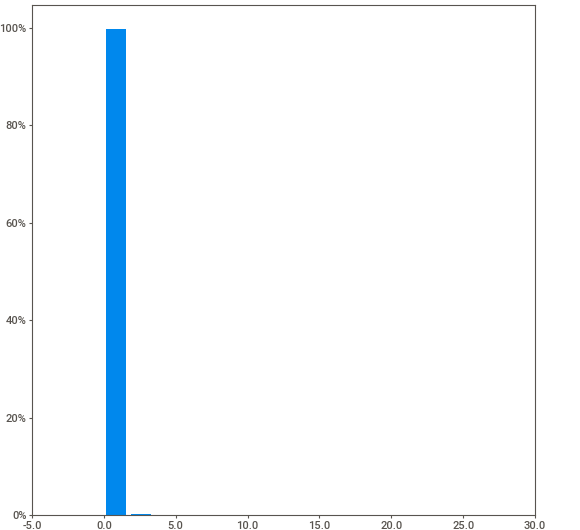
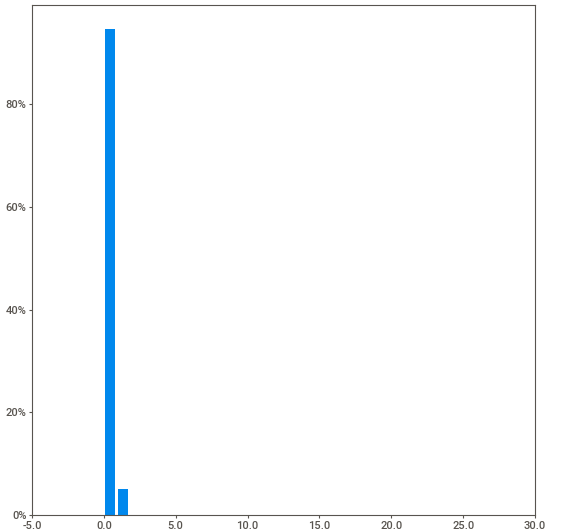
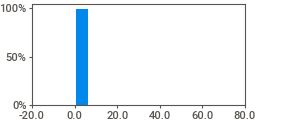
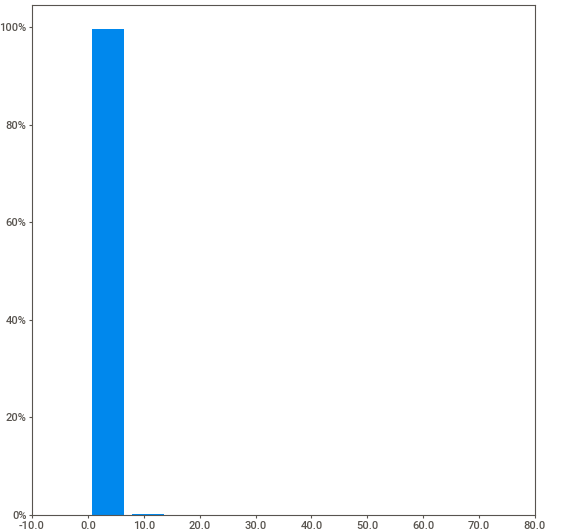
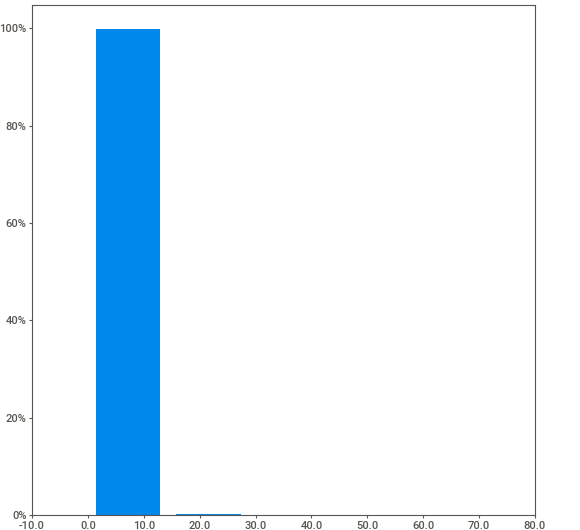
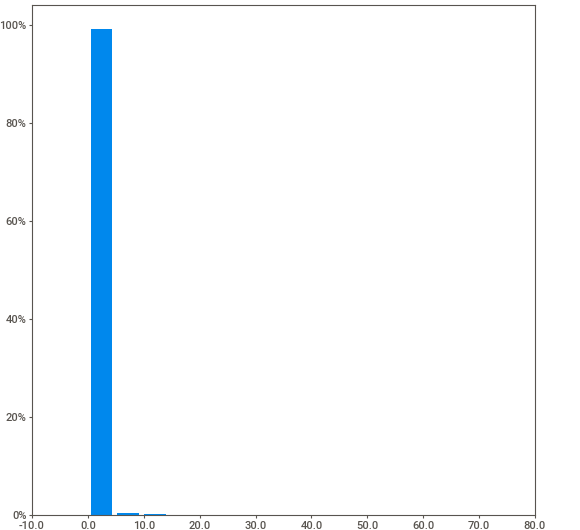
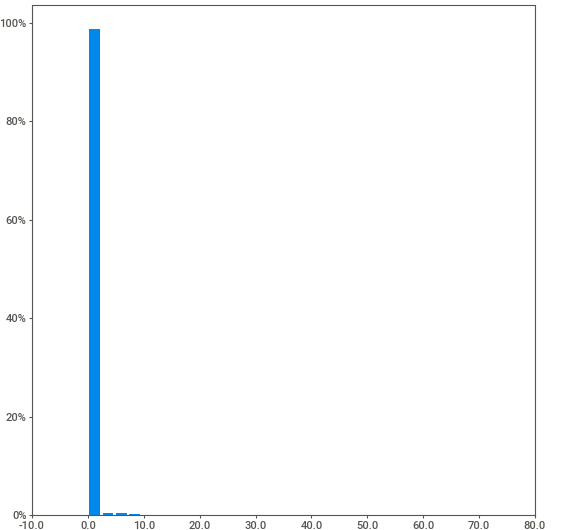
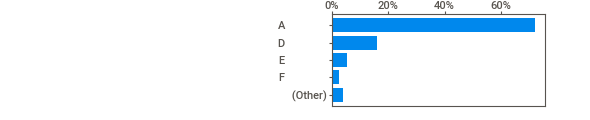
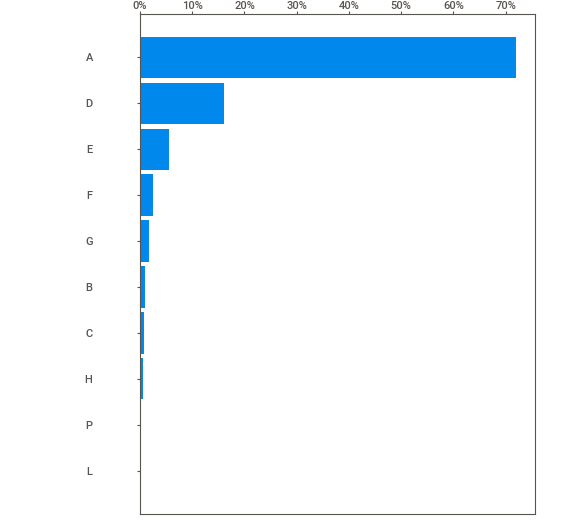
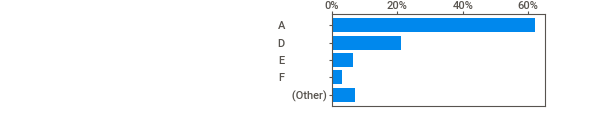
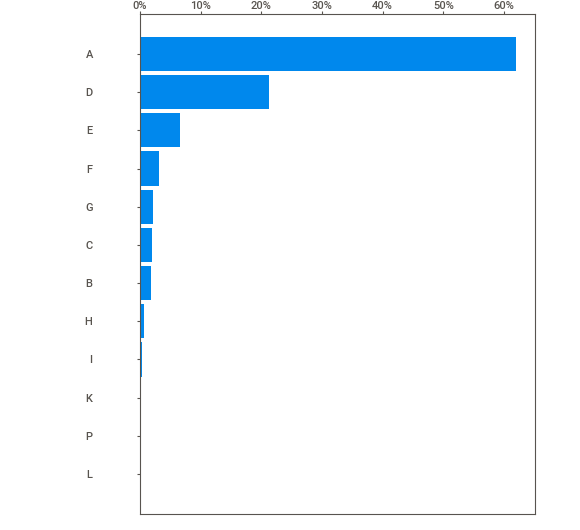
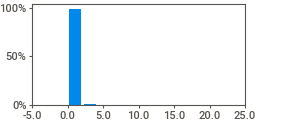
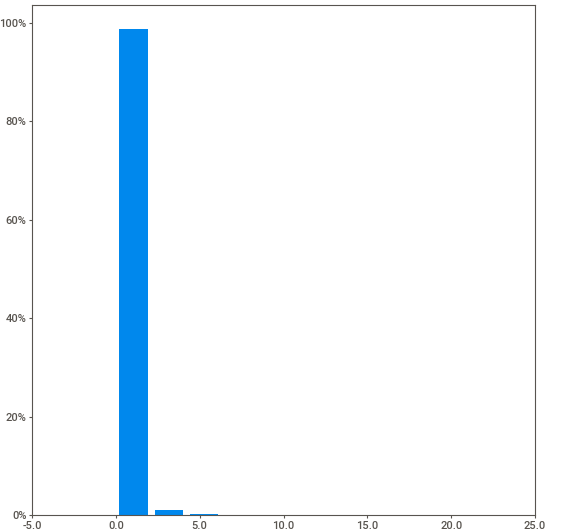
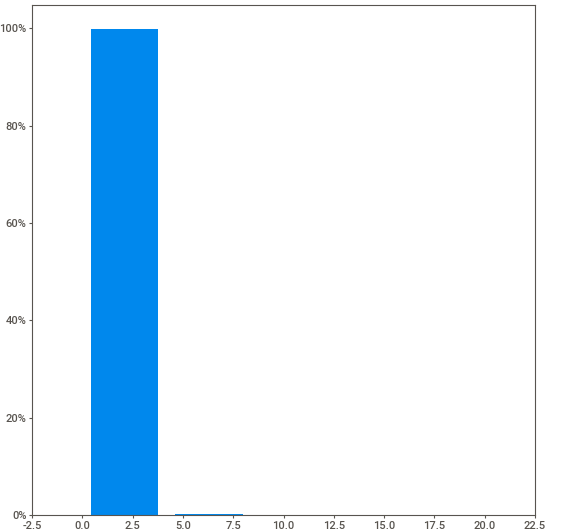
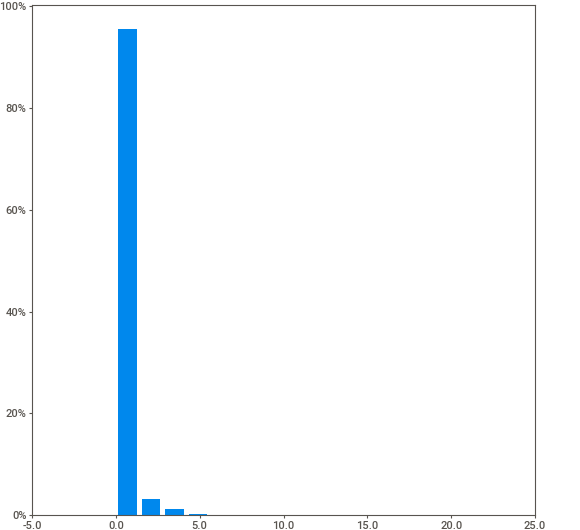
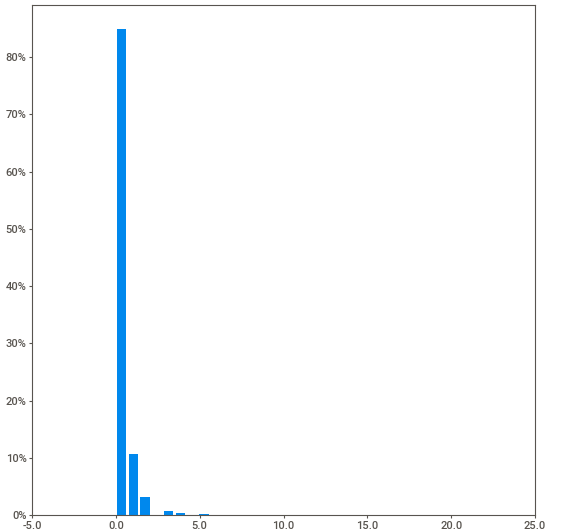
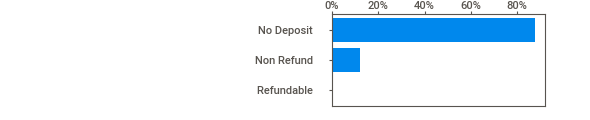
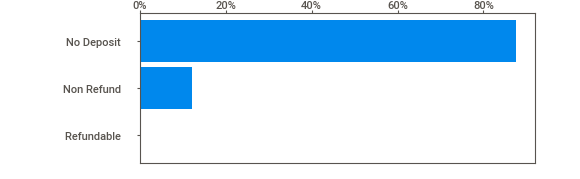
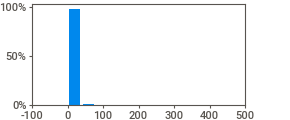
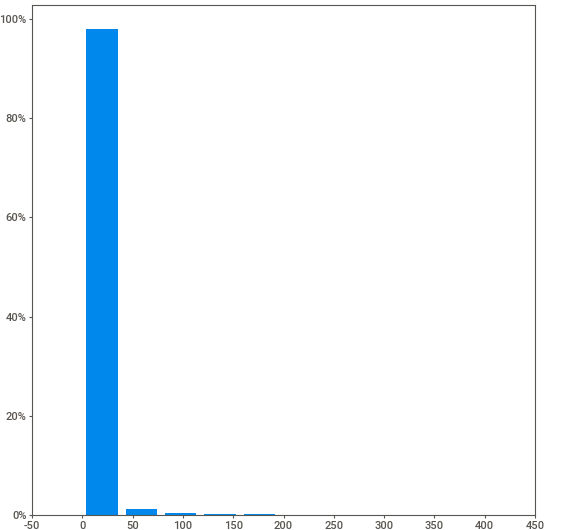
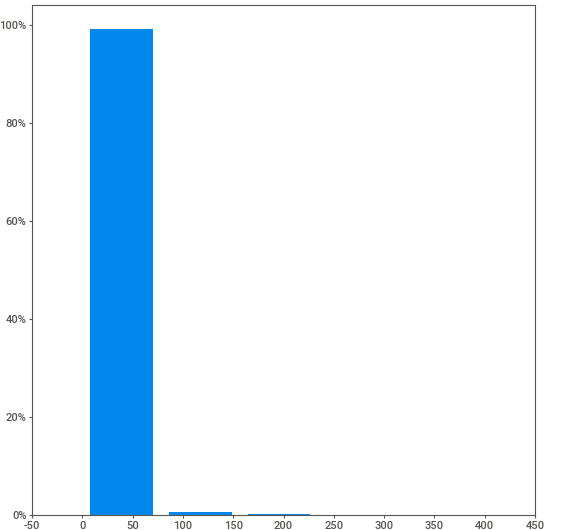
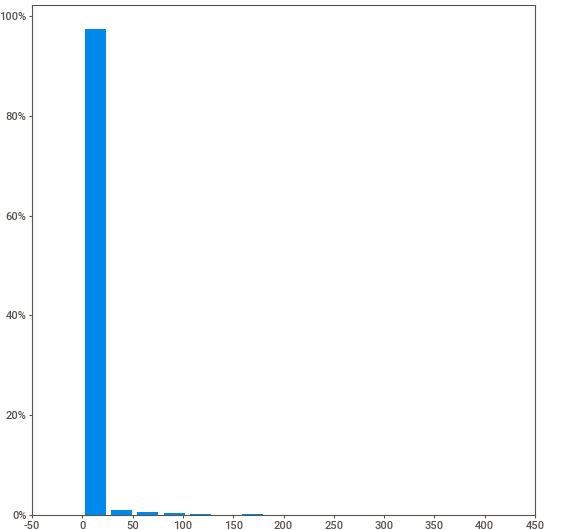
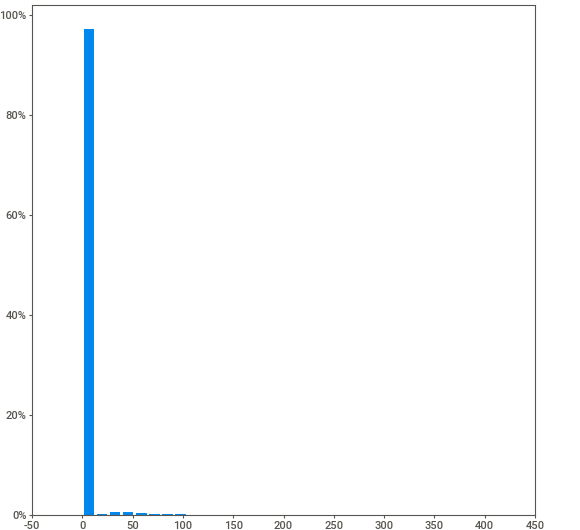
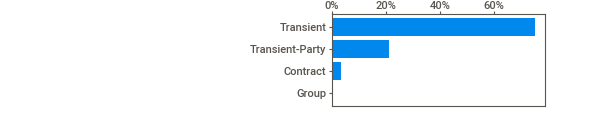
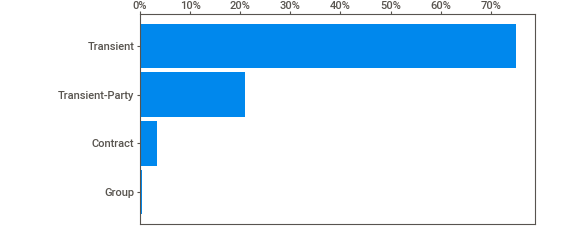
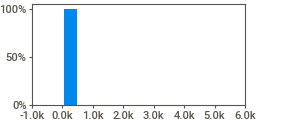
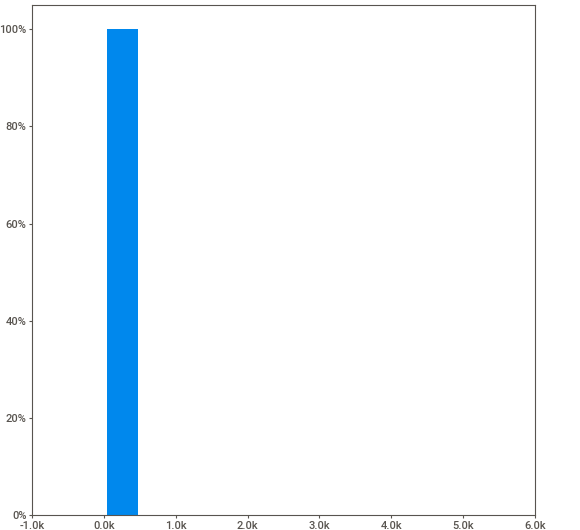
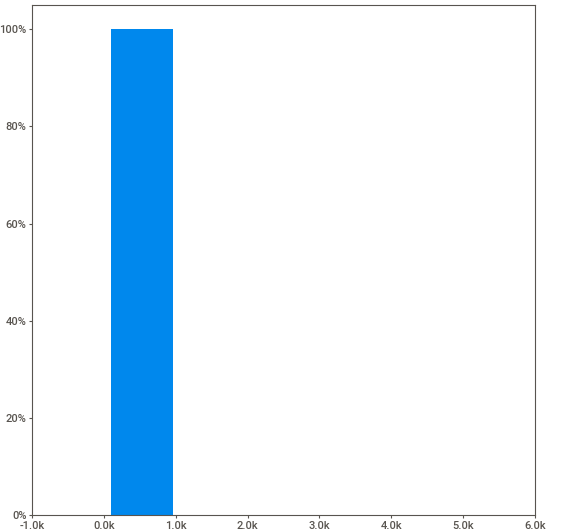
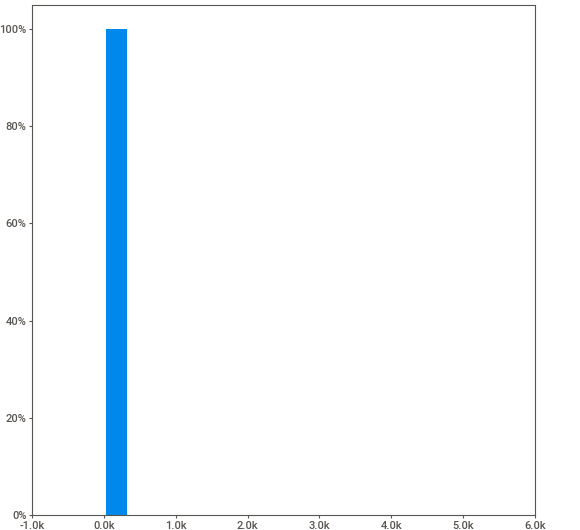
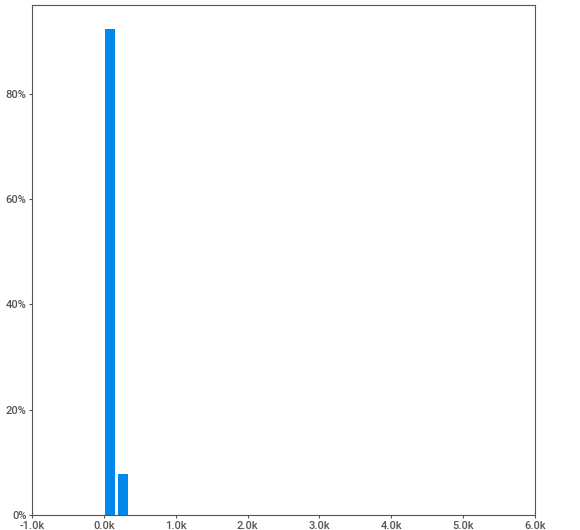
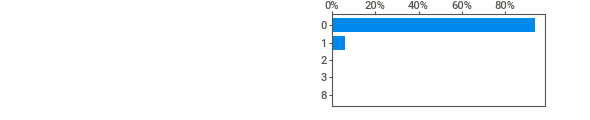
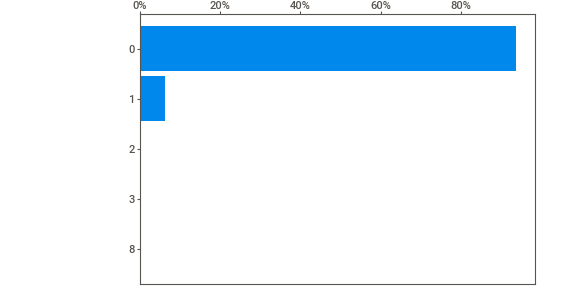
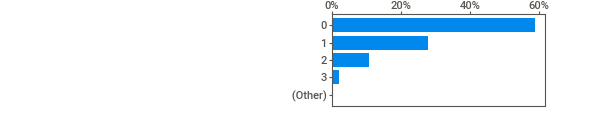
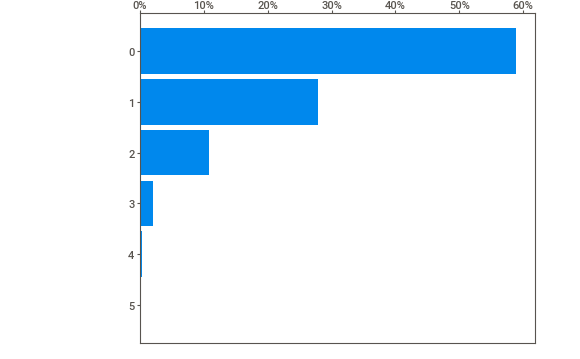
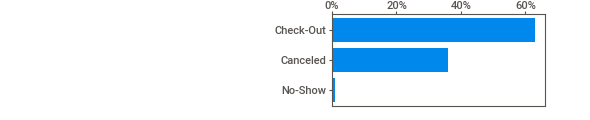
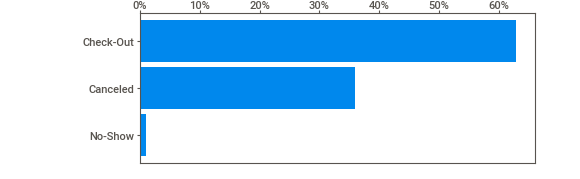
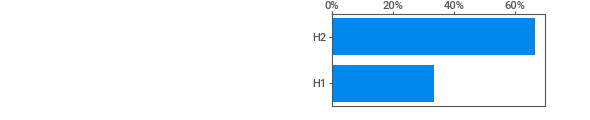
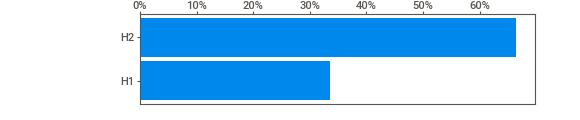

In [3]:
report = sv.analyze(data,pairwise_analysis = 'off')
report.show_notebook()

### **EDA Results**

---

**Feature Review**

1. **IsCanceled**: 
   - **Type**: Binary
   - **Notes**: This feature is too strongly related to the target feature, `ReservationStatus`, and will cause problems for modeling. I will drop this feature after completing my EDA.

2. **LeadTime**:
   - **Type**: Numeric, Continuous
   - **Distribution**: Right-skewed
   - **Action**: Consider applying a Yeo-Johnson transformation to correct skewness, or evaluate whether to drop extreme outliers if they are not representative of typical booking patterns.

3. **Date Features** (e.g., ArrivalDate, DepartureDate):
   - **Type**: DateTime
   - **Action**: Move these features to the feature engineering phase for generating time series details, such as day of the week, month, or seasonality effects.

4. **Adults, Children, Babies**:
   - **Type**: Numeric, Discrete
   - **Distribution**: Right-skewed
   - **Action**: Evaluate the necessity of transforming these features to reduce skewness or consider removing outliers that could distort the analysis.

5. **Meal**:
   - **Type**: Categorical
   - **Action**: Perform encoding during the modeling pipeline preprocessing to convert this feature into a format suitable for machine learning models.

6. **Country**:
   - **Type**: Categorical
   - **Action**: Encode this feature during preprocessing. Given the high cardinality (many unique countries), consider using a method that reduces dimensionality, such as frequency encoding or grouping similar countries.

7. **PreviousCancellations / PreviousBookingsNotCancelled**:
   - **Type**: Numeric, Discrete
   - **Notes**: These features are particularly useful for post-booking forecasts but are less applicable for pre-booking revenue forecasting. Their predictive power might be more relevant to behavioral analysis after a booking is made.

8. **BookedRoomType / AssignedRoomType**:
   - **Type**: Categorical
   - **Notes**: The `AssignedRoomType` is not known until after the stay, which makes it a candidate for feature engineering. You could explore classification models to predict the assigned room type or analyze the matching between booking and assignment.

9. **BookingChanges**:
   - **Type**: Numeric, Discrete
   - **Distribution**: Right-skewed
   - **Action**: Plan to transform this feature during preprocessing to manage skewness.

10. **DepositType**:
    - **Type**: Categorical
    - **Action**: Perform encoding during preprocessing.

11. **Agent, Company**:
    - **Type**: Categorical
    - **Action**: These features require encoding during preprocessing. Given potential high cardinality, consider using frequency encoding or similar techniques.

12. **DaysInWaitingList**:
    - **Type**: Numeric, Discrete
    - **Distribution**: Right-skewed
    - **Action**: This feature should be transformed during preprocessing to reduce skewness.

13. **ADR (Average Daily Rate)**:
    - **Type**: Numeric, Continuous
    - **Notes**: While no longer the target feature, ADR remains an important predictor. It has negative values that should be examined—decide whether to retain, drop, or adjust these values (e.g., bringing all values above zero). ADR is also right-skewed and could benefit from transformation (e.g., log or Yeo-Johnson) during preprocessing.

14. **RequiredParkingSpaces**:
    - **Type**: Numeric, Discrete
    - **Distribution**: Right-skewed
    - **Action**: Apply transformation during preprocessing to manage skewness.

15. **ReservationStatus** (Target Feature):
    - **Type**: Categorical
    - **Notes**: This feature indicates the final status of a reservation (e.g., canceled, checked-in, no-show). It is the target for classification modeling. It's important to avoid data leakage by ensuring that no features derived from this status are used inappropriately.

16. **ReservationStatusDate**:
    - **Type**: DateTime
    - **Action**: Utilize this feature in temporal feature engineering, such as calculating the time between booking and status change, or deriving features related to the timing of the status update.

---

 **Review Summary**

- **Numeric Features**: Several numeric features exhibit right-skewness and contain extreme outliers. These characteristics suggest that transformations, such as Yeo-Johnson, could be beneficial. However, in some cases, it may be appropriate to drop extreme outliers if they do not represent typical data patterns.

- **Categorical Features**: Many categorical features, especially those with high cardinality (e.g., `Country`, `Agent`, `Company`), will need encoding. To avoid the dimensionality explosion that comes with one-hot encoding, techniques like frequency encoding or grouping should be considered.

- **Multicollinearity**: Multicollinearity is a concern, particularly for linear models. It will be essential to evaluate and potentially remove highly correlated features using methods such as Variance Inflation Factor (VIF) analysis.

- **Target Feature (ReservationStatus)**: The target for classification, `ReservationStatus`, requires careful handling to ensure that features derived from it do not introduce data leakage into the model.

---

**Next Steps**

- **Outliers and Skewness**: Apply transformations such as Yeo-Johnson during the preprocessing phase to address skewness in numeric features. Consider dropping extreme outliers if they do not contribute meaningful information.

- **Categorical Encoding**: Implement encoding for categorical features during the modeling pipeline, focusing on methods that manage high cardinality, such as CountFrequencyEncoder.

- **Address Multicollinearity**: For linear models, use VIF analysis or similar methods to detect and mitigate multicollinearity among features.

- **Feature Engineering**: Incorporate time-based features and engineered features derived from `ReservationStatusDate` and other date features to enhance the model's predictive power.

---

## Dropping `IsCanceled` and Saving Results

In [4]:
data = data.drop(columns = 'IsCanceled')
data

LeadTime  ArrivalDateYear ArrivalDateMonth  ArrivalDateWeekNumber  \
0            342             2015             July                     27   
1            737             2015             July                     27   
2              7             2015             July                     27   
3             13             2015             July                     27   
4             14             2015             July                     27   
...          ...              ...              ...                    ...   
119385        23             2017           August                     35   
119386       102             2017           August                     35   
119387        34             2017           August                     35   
119388       109             2017           August                     35   
119389       205             2017           August                     35   

        ArrivalDateDayOfMonth  StaysInWeekendNights  StaysInWeekNights  \
0                           1                     0                  0   
1                           1                     0                  0   
2                           1                     0                  1   
3                           1                     0                  1   
4                           1                     0                  2   
...                       ...                   ...                ...   
119385                     30                     2                  5   
119386                     31                     2                  5   
119387                     31                     2                  5   
119388                     31                     2                  5   
119389                     29                     2                  7   

        Adults  Children  Babies       Meal Country  MarketSegment  \
0            2      0.00       0  BB            PRT         Direct   
1            2      0.00       0  BB            PRT         Direct   
2            1      0.00       0  BB            GBR         Direct   
3            1      0.00       0  BB            GBR      Corporate   
4            2      0.00       0  BB            GBR      Online TA   
...        ...       ...     ...        ...     ...            ...   
119385       2      0.00       0  BB            BEL  Offline TA/TO   
119386       3      0.00       0  BB            FRA      Online TA   
119387       2      0.00       0  BB            DEU      Online TA   
119388       2      0.00       0  BB            GBR      Online TA   
119389       2      0.00       0  HB            DEU      Online TA   

       DistributionChannel  IsRepeatedGuest  PreviousCancellations  \
0                   Direct                0                      0   
1                   Direct                0                      0   
2                   Direct                0                      0   
3                Corporate                0                      0   
4                    TA/TO                0                      0   
...                    ...              ...                    ...   
119385               TA/TO                0                      0   
119386               TA/TO                0                      0   
119387               TA/TO                0                      0   
119388               TA/TO                0                      0   
119389               TA/TO                0                      0   

        PreviousBookingsNotCanceled  ReservedRoomType  AssignedRoomType  \
0                                 0  C                 C                  
1                                 0  C                 C                  
2                                 0  A                 C                  
3                                 0  A                 A                  
4                                 0  A                 A                  
...                             ...               ...         

# Exploratory Data Analysis: Summary Stats

In [5]:
## Numeric Stats
data.describe(include = 'number').T

count     mean    std      min      25%  \
LeadTime                    119,390.00   104.01 106.86     0.00    18.00   
ArrivalDateYear             119,390.00 2,016.16   0.71 2,015.00 2,016.00   
ArrivalDateWeekNumber       119,390.00    27.17  13.61     1.00    16.00   
ArrivalDateDayOfMonth       119,390.00    15.80   8.78     1.00     8.00   
StaysInWeekendNights        119,390.00     0.93   1.00     0.00     0.00   
StaysInWeekNights           119,390.00     2.50   1.91     0.00     1.00   
Adults                      119,390.00     1.86   0.58     0.00     2.00   
Children                    119,386.00     0.10   0.40     0.00     0.00   
Babies                      119,390.00     0.01   0.10     0.00     0.00   
IsRepeatedGuest             119,390.00     0.03   0.18     0.00     0.00   
PreviousCancellations       119,390.00     0.09   0.84     0.00     0.00   
PreviousBookingsNotCanceled 119,390.00     0.14   1.50     0.00     0.00   
BookingChanges              119,390.00     0.22   0.65     0.00     0.00   
DaysInWaitingList           119,390.00     2.32  17.59     0.00     0.00   
ADR                         119,390.00   101.83  50.54    -6.38    69.29   
RequiredCarParkingSpaces    119,390.00     0.06   0.25     0.00     0.00   
TotalOfSpecialRequests      119,390.00     0.57   0.79     0.00     0.00   

                                 50%      75%      max  
LeadTime                       69.00   160.00   737.00  
ArrivalDateYear             2,016.00 2,017.00 2,017.00  
ArrivalDateWeekNumber          28.00    38.00    53.00  
ArrivalDateDayOfMonth          16.00    23.00    31.00  
StaysInWeekendNights            1.00     2.00    19.00  
StaysInWeekNights               2.00     3.00    50.00  
Adults                          2.00     2.00    55.00  
Children                        0.00     0.00    10.00  
Babies                          0.00     0.00    10.00  
IsRepeatedGuest                 0.00     0.00     1.00  
PreviousCancellations           0.00     0.00    26.00  
PreviousBookingsNotCanceled     0.00     0.00    72.00  
BookingChanges                  0.00     0.00    21.00  
DaysInWaitingList               0.00     0.00   391.00  
ADR                            94.58   126.00 5,400.00  
RequiredCarParkingSpaces        0.00     0.00     8.00  
TotalOfSpecialRequests          0.00     1.00     5.00

---

- Outliers present in nearly half of the features
- Power transformations/removal may be required in preprocessing pipeline to minimize impact on models

---

In [6]:
## Non-Numeric Stats
data.describe(exclude = 'number').T

count unique               top    freq
ArrivalDateMonth       119390     12            August   13877
Meal                   119390      5         BB          92310
Country                118902    177               PRT   48590
MarketSegment          119390      8         Online TA   56477
DistributionChannel    119390      5             TA/TO   97870
ReservedRoomType       119390     10  A                  85994
AssignedRoomType       119390     12  A                  74053
DepositType            119390      3   No Deposit       104641
Agent                  119390    334                 9   31961
Company                119390    353              NULL  112593
CustomerType           119390      4         Transient   89613
ReservationStatus      119390      3         Check-Out   75166
ReservationStatusDate  119390    926        2015-10-21    1461
HotelNumber            119390      2                H2   79330

---

- High cardinality in Country, Agent, Company

---

# Review Missing Values

In [7]:
nan_sum = data.isna().sum()
nan_sum[nan_sum > 0]

Children      4
Country     488
dtype: int64

In [8]:
nan_avg = data.isna().mean()
nan_avg[nan_avg > 0]

Children   0.00
Country    0.00
dtype: float64

---

- Two features missing values
- Average number of missing values less than 1%
- No action taken; will address in model pipeline

---

# Condensing `ReservationStatus` Classes

In [9]:
data.loc[:, 'ReservationStatus'] = np.where(data['ReservationStatus'] == 'No-Show','Canceled',data['ReservationStatus'])
data['ReservationStatus'].value_counts(normalize=True).round(2)

ReservationStatus
Check-Out   0.63
Canceled    0.37
Name: proportion, dtype: float64

In [10]:
data.to_parquet('../../data/source/full_data.parquet')

# Inspecting Canceled Reservations

In [14]:
cxl_res = data[data['ReservationStatus'] == 'Canceled']
cxl_res

LeadTime  ArrivalDateYear ArrivalDateMonth  ArrivalDateWeekNumber  \
8             85             2015             July                     27   
9             75             2015             July                     27   
10            23             2015             July                     27   
27            60             2015             July                     27   
32            96             2015             July                     27   
...          ...              ...              ...                    ...   
110280       132             2017            April                     17   
111355         4             2017             June                     23   
111924         7             2017              May                     22   
111925         6             2017             July                     29   
117295         0             2017           August                     31   

        ArrivalDateDayOfMonth  StaysInWeekendNights  StaysInWeekNights  \
8                           1                     0                  3   
9                           1                     0                  3   
10                          1                     0                  4   
27                          1                     2                  5   
32                          1                     2                  8   
...                       ...                   ...                ...   
110280                     25                     0                  0   
111355                      5                     1                  0   
111924                     31                     0                  1   
111925                     17                     1                  0   
117295                      2                     0                  2   

        Adults  Children  Babies       Meal Country  MarketSegment  \
8            2      0.00       0  BB            PRT      Online TA   
9            2      0.00       0  HB            PRT  Offline TA/TO   
10           2      0.00       0  BB            PRT      Online TA   
27           2      0.00       0  BB            PRT      Online TA   
32           2      0.00       0  BB            PRT         Direct   
...        ...       ...     ...        ...     ...            ...   
110280       0      0.00       0  BB            FRA      Online TA   
111355       1      0.00       0  BB            PRT      Corporate   
111924       1      0.00       0  BB            PRT      Corporate   
111925       1      0.00       0  BB            PRT      Corporate   
117295       1      0.00       0  BB            PRT      Corporate   

       DistributionChannel  IsRepeatedGuest  PreviousCancellations  \
8                    TA/TO                0                      0   
9                    TA/TO                0                      0   
10                   TA/TO                0                      0   
27                   TA/TO                0                      0   
32                  Direct                0                      0   
...                    ...              ...                    ...   
110280               TA/TO                0                      0   
111355           Corporate                1                      0   
111924           Corporate                1                      0   
111925           Corporate                1                      1   
117295           Corporate                1                      0   

        PreviousBookingsNotCanceled  ReservedRoomType  AssignedRoomType  \
8                                 0  A                 A                  
9                                 0  D                 D                  
10                                0  E                 E                  
27                                0  E                 E                  
32                                0  E                 E                  
...                             ...               ...         

In [15]:
cxl_res.describe(include = 'number').T

count     mean    std      min      25%  \
LeadTime                    44,224.00   144.85 118.62     0.00    48.00   
ArrivalDateYear             44,224.00 2,016.17   0.71 2,015.00 2,016.00   
ArrivalDateWeekNumber       44,224.00    27.31  13.08     1.00    17.00   
ArrivalDateDayOfMonth       44,224.00    15.73   8.79     1.00     8.00   
StaysInWeekendNights        44,224.00     0.93   1.01     0.00     0.00   
StaysInWeekNights           44,224.00     2.56   1.88     0.00     1.00   
Adults                      44,224.00     1.90   0.68     0.00     2.00   
Children                    44,220.00     0.11   0.41     0.00     0.00   
Babies                      44,224.00     0.00   0.06     0.00     0.00   
IsRepeatedGuest             44,224.00     0.01   0.11     0.00     0.00   
PreviousCancellations       44,224.00     0.21   1.33     0.00     0.00   
PreviousBookingsNotCanceled 44,224.00     0.03   0.68     0.00     0.00   
BookingChanges              44,224.00     0.10   0.45     0.00     0.00   
DaysInWaitingList           44,224.00     3.56  21.49     0.00     0.00   
ADR                         44,224.00   104.96  52.57     0.00    72.42   
RequiredCarParkingSpaces    44,224.00     0.00   0.00     0.00     0.00   
TotalOfSpecialRequests      44,224.00     0.33   0.65     0.00     0.00   

                                 50%      75%      max  
LeadTime                      113.00   214.00   629.00  
ArrivalDateYear             2,016.00 2,017.00 2,017.00  
ArrivalDateWeekNumber          27.00    38.00    53.00  
ArrivalDateDayOfMonth          16.00    23.00    31.00  
StaysInWeekendNights            1.00     2.00    16.00  
StaysInWeekNights               2.00     3.00    40.00  
Adults                          2.00     2.00    55.00  
Children                        0.00     0.00    10.00  
Babies                          0.00     0.00     2.00  
IsRepeatedGuest                 0.00     0.00     1.00  
PreviousCancellations           0.00     0.00    26.00  
PreviousBookingsNotCanceled     0.00     0.00    58.00  
BookingChanges                  0.00     0.00    16.00  
DaysInWaitingList               0.00     0.00   391.00  
ADR                            96.20   127.62 5,400.00  
RequiredCarParkingSpaces        0.00     0.00     0.00  
TotalOfSpecialRequests          0.00     0.00     5.00

# Feature Selection - Known at Booking/Pre-Arrival

---

While some of the features in my dataset may not be known at the time of booking, **I will retain almost all of the source features for my initial modeling efforts.** This approach allows me to assess the overall predictive power of the model using the full feature set.

If the initial models perform well, I will then refine the feature selection by removing those features that are less likely to be known at the time of booking. This step will help ensure that the model more accurately reflects the reservation process and improves its applicability in real-world scenarios.

---

# **Final Summary and Next Steps**

---

The exploratory data analysis (EDA) process has provided a comprehensive understanding of the dataset, highlighting key characteristics, potential issues, and opportunities for feature engineering.

Several numeric features were found to be right-skewed with notable outliers, while categorical features often exhibited high cardinality. The analysis also revealed a degree of multicollinearity, particularly concerning for linear models, which will need to be addressed during the modeling process.

Additionally, while the target feature for classification, `ReservationStatus`, is crucial for predicting outcomes, careful consideration is needed to avoid data leakage from features that may not be known at the time of booking.

---

**Next Steps**

1. **Baseline Modeling**: 
   - Begin by developing baseline models using the full set of features identified during the EDA. This will provide an initial understanding of the model's performance and help identify which features contribute most to the predictions.

2. **Feature Engineering**:
   - After establishing the baseline, proceed with feature engineering to create new, potentially more predictive features. This includes deriving temporal features from date-related data and calculating occupancy statistics for each hotel.

3. **Dataset Expansion**:
   - Expand the dataset as described earlier by creating daily records for each reservation. This will allow for the calculation of daily occupancy rates and other time-sensitive metrics that can be used as additional features in the model.


***Above and Beyond***

- Based on the initial model performance, iteratively refine the feature set by removing features that are less likely to be known at the time of booking. This step will help align the model more closely with the real-world reservation process and improve its generalizability.

---

**Final Notes**

By following these steps, the project will transition from EDA to more advanced modeling, enabling a deeper analysis of reservation patterns and ultimately leading to more accurate predictions of reservation outcomes.

---